# # Modelagem 1-dim 64 MFCCs

In [1]:
import keras as K
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from random import choice

from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

%matplotlib inline

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DIR_DATAFRAMES = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/DATAFRAMES'
DIR_MFCC = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC'

In [4]:
!ls -lah $DIR_DATAFRAMES

total 4,1G
drwxrwxrwx 1 hbrandao hbrandao 4,0K mar 21 23:15 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 21 23:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 181K mar 21 23:27 Xfusao.csv
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 372M mar 23 00:32 Xsinal.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_stretch_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_tile_0padded.npy


In [5]:
!ls -lahR $DIR_MFCC

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC:
total 0
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:49 .
drwxrwxrwx 1 hbrandao hbrandao 0 mar 21 23:49 ..
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:55 128
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:54 64
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:53 mean

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/128:
total 944M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:55 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_pad_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_stretch_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:11 Xsinal_tile_128mfcc.npy

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/64:
total 472M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:54 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 158M mar 22 02:05 Xsinal_pad_64mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 158M 

In [6]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
if PHYS_DEVICE_NAME:
    print(PHYS_DEVICE_NAME)
else:
    raise Exception('GPU não encontrada')

GPU:0


2023-04-15 23:11:30.866174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 23:11:30.884460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 23:11:30.884601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dados
___

In [7]:
X64 = np.load(f'{DIR_MFCC}/mean/Xsinal_64mfcc_mean.npy')

x64train, x64test, *_ = train_test_split(X64)
x64train.shape, x64test.shape

((1023, 64), (341, 64))

## Autoencoder
___

In [8]:
dim = X64.shape[-1]

In [9]:
def autoencoder64():
    inp_enc = K.Input(batch_shape=(1,dim))
    enc = layers.Dense(units=int(dim/2), activation='relu')(inp_enc)
    encoder = K.Model(inp_enc, enc)

    inp_dec = K.Input(batch_shape=(1,int(dim/2)))
    dec = layers.Dense(units=dim, activation='linear')(inp_dec)
    decoder = K.Model(inp_dec, dec)

    inp_ae = K.Input(batch_shape=(1,dim))
    enc_ae = encoder(inp_ae)
    dec_ae = decoder(enc_ae)

    ae = K.Model(inp_ae, dec_ae, name='autoencoder')
    ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return ae, encoder, decoder

### x64 train

In [19]:
epochs = 1000

es = EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=20, verbose=1)

# mc = ModelCheckpoint('autoencoder_mean_64mfcc.hdf5',
#                      monitor='loss', verbose=1, save_best_only=True, mode='min')

with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    modelo64, encoder64, decoder64 = autoencoder64()
    history = modelo64.fit(x=x64train,
                           y=x64train,
                           epochs=epochs,
                           batch_size=10,
                           shuffle=True,
                           validation_data=(x64test, x64test),
                           verbose=0,
                           callbacks=[es]#, mc]
                          )

Epoch 00186: early stopping


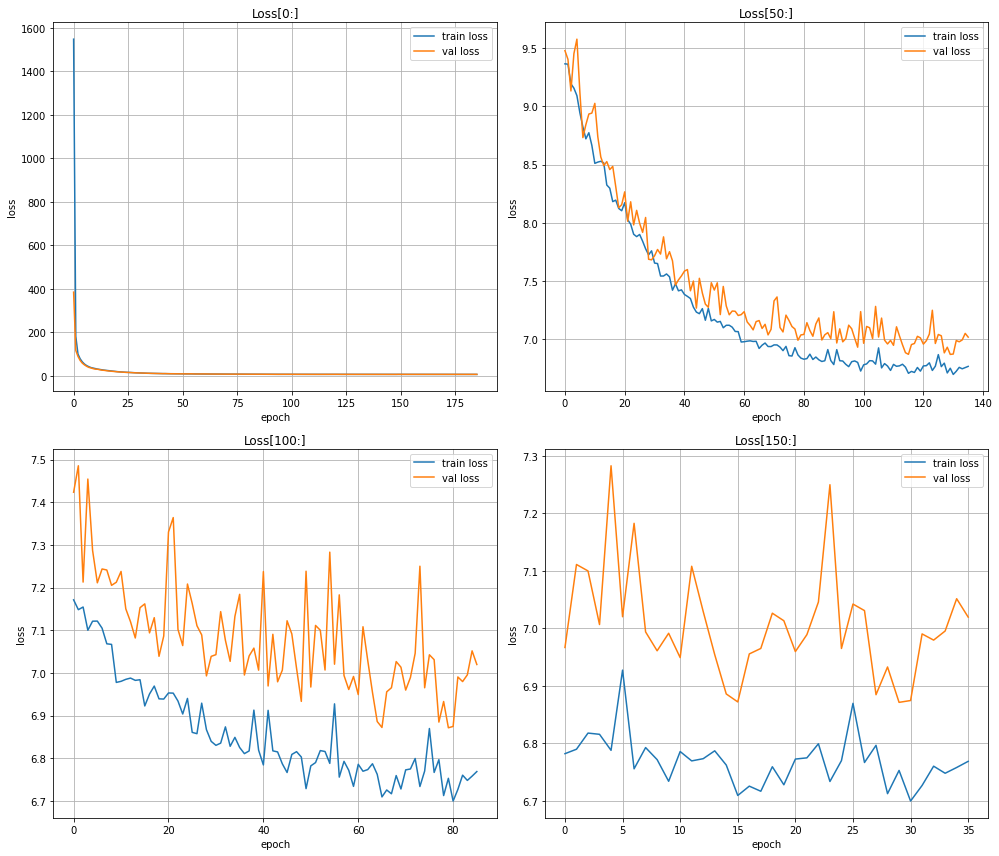

In [20]:
plt.figure(figsize=(14, 12))

row, col = 2, 2

for i,r in enumerate((0, 50, 100, 150)):
    plt.subplot(row,col,i+1)
    plt.plot(history.history['loss'][r:])
    plt.plot(history.history['val_loss'][r:])
    plt.title(f'Loss[{r}:]')
    plt.legend(['train loss', 'val loss'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

plt.tight_layout()
plt.show()

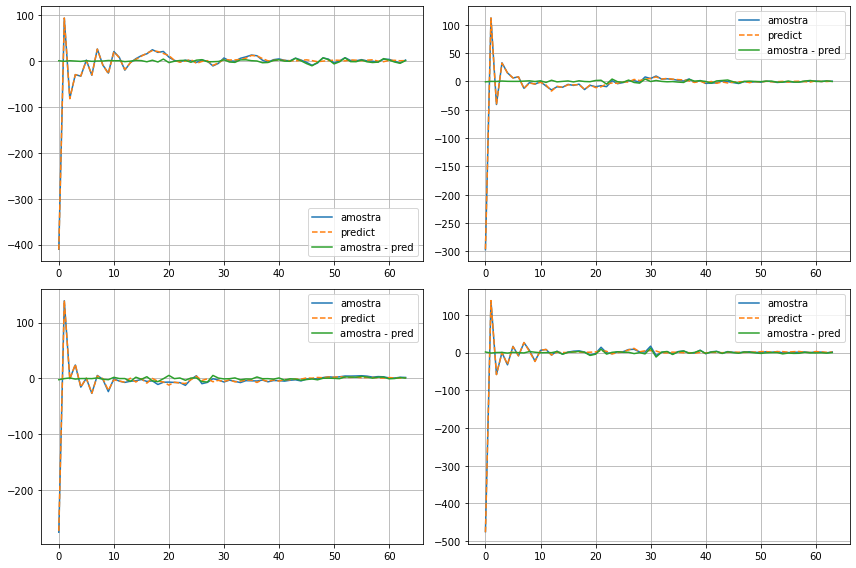

In [21]:
plt.figure(figsize=(12,8))

row, col, idx = 2, 2, 1

for i in range(row*col):
    reg = choice(x64train).reshape(1,dim)
    pred = modelo64.predict(reg)
    diff = reg - pred

    plt.subplot(row, col, idx)
    plt.plot(reg.flatten(), label='amostra')
    plt.plot(pred.flatten(), label='predict', linestyle='--')
    plt.plot(diff.flatten(), label='amostra - pred')
    plt.legend()
    plt.grid()
    idx += 1

plt.tight_layout()
plt.show()

In [22]:
pred_x64 = modelo64.predict(x64test)
loss_x64 = K.losses.mse(pred_x64, x64test)

np.mean(loss_x64)

7.019594

In [23]:
#
#
modelo64 = K.models.load_model('autoencoder_mean_64mfcc.hdf5')
#
#

In [24]:
pred_x64 = modelo64.predict(x64test)
loss_x64 = K.losses.mse(pred_x64, x64test)

np.mean(loss_x64)

6.400986

### x64 train MinMax scaled

In [ ]:
# x64scaled = MinMaxScaler().fit_transform(X64)
# x64train_scaled, x64test_scaled, *_ = train_test_split(X64)

# x64train_scaled.shape, x64test_scaled.shape

In [ ]:
# epochs = 1000

# es = EarlyStopping(monitor='loss',
#                    mode='min',
#                    min_delta=0.01,
#                    patience=20,
#                    verbose=1)

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     modelo64_scaled, *_ = autoencoder64()
#     history = modelo64_scaled.fit(x=x64train_scaled,
#                                   y=x64train_scaled,
#                                   epochs=epochs,
#                                   batch_size=10,
#                                   shuffle=True,
#                                   validation_data=(x64test_scaled, x64test_scaled),
#                                   callbacks=[es])

In [ ]:
# plt.figure(figsize=(14, 12))

# row, col = 2, 2

# for i,r in enumerate((0, 50, 100, 150)):
#     plt.subplot(row,col,i+1)
#     plt.plot(history.history['loss'][r:])
#     plt.plot(history.history['val_loss'][r:])
#     plt.title(f'Loss[{r}:]')
#     plt.legend(['train loss', 'val loss'], loc='upper right')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.grid()

# plt.tight_layout()
# plt.show()

In [ ]:
# plt.figure(figsize=(12,8))

# row, col, idx = 2, 2, 1

# for i in range(row*col):
#     reg = choice(x64train_scaled).reshape(1,dim)
#     pred = modelo64_scaled.predict(reg)
#     diff = reg - pred

#     plt.subplot(row, col, idx)
#     plt.plot(reg.flatten(), label='amostra_scaled')
#     plt.plot(pred.flatten(), label='predict_scaled', linestyle='--')
#     plt.plot(diff.flatten(), label='amostra_scaled - pred_scaled')
#     plt.legend()
#     plt.grid()
#     idx += 1

# plt.tight_layout()
# plt.show()

In [ ]:
# pred_x64_scaled = modelo64_scaled.predict(x64test_scaled)
# loss_x64_scaled = K.losses.mse(pred_x64_scaled, x64test_scaled)

# np.mean(loss_x64_scaled)

#### Tentando um Autoencoder mais profundo

In [ ]:
# def deep_autoencoder64():
#     K.backend.clear_session()

#     input64 = K.Input(batch_shape=(1,dim))

#     encoder64 = layers.Dense(units=int(dim/2), activation='relu')(input64)
#     encoder64 = layers.Dropout(0.25)(encoder64)
#     encoder64 = layers.Dense(units=int(dim/2), activation='relu')(encoder64)

#     decoder64 = layers.Dropout(0.25)(encoder64)
#     decoder64 = layers.Dense(units=int(dim/2), activation='relu')(decoder64)
#     decoder64 = layers.Dropout(0.25)(decoder64)
#     decoder64 = layers.Dense(units=dim, activation='linear')(decoder64)

#     ae64 = K.Model(input64, decoder64, name='deep_autoencoder64')
#     ae64.compile(optimizer='adam', loss='mse', metrics=['mae'])

#     print(ae64.summary())

#     return ae64

# deep_autoencoder64()

In [ ]:
# epochs = 1000

# es = EarlyStopping(monitor='loss',
#                    mode='min',
#                    min_delta=0.01,
#                    patience=20,
#                    verbose=1)

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     deep_modelo64 = deep_autoencoder64()
#     history = deep_modelo64.fit(x=x64train,
#                                 y=x64train,
#                                 epochs=epochs,
#                                 batch_size=10,
#                                 shuffle=True,
#                                 validation_data=(x64test, x64test),
#                                 callbacks=[es],
#                                )

In [ ]:
# np.mean(
#     K.losses.mse(deep_modelo64.predict(x64test), x64test)
# )

Dados os experimentos, podemos assumir que o Autoencoder (`modelo64`) com dados não normalizados apresenta a melhor performance

In [ ]:
# del x64train, x64test
# del x64scaled, x64train_scaled, x64test_scaled
# del modelo64_scaled, deep_modelo64

## Classificador

In [25]:
X64.shape

(1364, 64)

In [26]:
Xfusao = pd.read_csv(f'{DIR_DATAFRAMES}/Xfusao.csv', delimiter=';')
Xfusao.shape

(1364, 8)

In [27]:
Xfusao.head()

,path,dataset,arquivo,pessoa,genero,emocao,intensidade,duracao
0,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l1.wav,f1,f,alegria,NaN,2.451610
1,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l2.wav,f1,f,alegria,NaN,3.916553
2,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l3.wav,f1,f,alegria,NaN,3.482993
3,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l4.wav,f1,f,alegria,NaN,3.684354
4,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l5.wav,f1,f,alegria,NaN,2.343061


In [28]:
DE_PARA_EMOCAO = {
    'alegria': np.array([1,0,0,0]),
    'medo': np.array([0,1,0,0]),
    'raiva': np.array([0,0,1,0]),
    'surpresa': np.array([0,0,0,1]),
}

DE_PARA_INTENSIDADE = {
    'fraca': np.array([1,0,0,0]),
    'moderada': np.array([0,1,0,0]),
    'forte': np.array([0,0,1,0]),
    'pico': np.array([0,0,0,1]),
}

def encoding_emocao(emocao: str):
    return DE_PARA_EMOCAO.get(emocao)

def encoding_intensidade(intensidade: str):
    return DE_PARA_INTENSIDADE.get(intensidade)

In [29]:
Xfusao['emo'] = Xfusao['emocao'].apply(encoding_emocao)
Xfusao['int'] = Xfusao['intensidade'].apply(encoding_intensidade)

In [30]:
Xfusao.drop(labels=['path', 'pessoa', 'genero', 'duracao', 'emocao', 'intensidade'],
            axis=1, inplace=True)

In [31]:
Xfusao.tail()

,dataset,arquivo,emo,int
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]"
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]"
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]"
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]"
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]"


In [32]:
Xfusao = pd.concat(objs=[Xfusao, pd.DataFrame(X64)], axis=1)
Xfusao.tail()

,dataset,arquivo,emo,int,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]",-429.589874,133.411682,-50.135876,-2.183036,-23.552435,16.127447,...,-0.139971,2.148980,0.202220,3.275567,-0.529448,-0.181059,4.731008,0.363102,0.874546,2.543077
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]",-464.718903,134.753693,-7.355528,23.141539,-41.095829,-12.439143,...,3.822853,2.926050,-2.851189,3.309691,0.376164,-0.513694,1.384362,2.246764,0.847502,-1.558109
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]",-335.451172,-14.470435,-37.541733,-11.240404,-18.821291,18.479385,...,0.819087,-0.181811,1.292265,-1.130435,5.381464,-1.318466,-2.149301,3.814080,-0.214485,2.099050
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-282.711945,70.662437,-39.934624,-4.440723,-53.481644,-15.649154,...,1.302397,-0.589643,-0.325025,5.137481,2.956725,-3.193030,-2.849084,5.133433,3.861740,0.229049
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-399.486450,103.588158,-58.144569,-14.114857,-41.650688,10.208106,...,1.302480,1.885603,-0.327338,-0.116328,2.800063,3.395798,-0.581741,1.221288,1.824211,2.366567


In [33]:
Xfusao_verbo = Xfusao[Xfusao['dataset'] == 'verbo']
Xfusao_verbo.shape

(666, 68)

In [34]:
Xfusao_vivae = Xfusao[Xfusao['dataset'] == 'vivae']
Xfusao_vivae.shape

(698, 68)

In [35]:
def realizar_encoding(x, dim=dim):
    return encoder64(x.reshape(1,dim).astype('float32'))

In [36]:
x64_vivae_enc = np.array([realizar_encoding(x) for x in Xfusao_vivae.values[:,4:]])
x64_vivae_enc.shape

(698, 1, 32)

In [37]:
y64_vivae = np.array([x.reshape(1,4) for x in Xfusao_vivae['int'].values])
y64_vivae.shape

(698, 1, 4)

In [38]:
xtrain, xtest, ytrain, ytest = train_test_split(x64_vivae_enc, y64_vivae)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((523, 1, 32), (523, 1, 4), (175, 1, 32), (175, 1, 4))

### Modelo

In [39]:
def modelo_clf_intensidade():
    K.backend.clear_session()
    modelo = K.Sequential()
    modelo.add(layers.Dense(units=32, activation='relu', input_shape=(1,32)))
    modelo.add(layers.Dense(units=16, activation='relu'))
    modelo.add(layers.Dense(units=8, activation='relu'))
    modelo.add(layers.Dense(units=4, activation='softmax'))

    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(modelo.summary())
    return modelo

modelo_clf_intensidade()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              136       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              36        
Total params: 1,756
Trainable params: 1,756
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
epochs = 1000

es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=20, verbose=1)

# mc = ModelCheckpoint('classificador_intensidade_64mfcc_encoded.hdf5',
#                      monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    clf_intensidade = modelo_clf_intensidade()
    history = clf_intensidade.fit(x=xtrain,
                                  y=ytrain,
                                  epochs=epochs,
                                  batch_size=2,
                                  shuffle=True,
                                  validation_data=(xtest, ytest),
                                  verbose=0,
                                  callbacks=[es]#, mc]
                                 )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              136       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              36        
Total params: 1,756
Trainable params: 1,756
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_accuracy improved from -inf to 0.27429, saving model to classificador_intensidade_64mfcc_encoded.hdf5

Epoch 00002: val_accuracy improved from 0.27429 to 0.29143, saving model to classificador_intensidade_64mfcc_encoded.hdf5

Epo

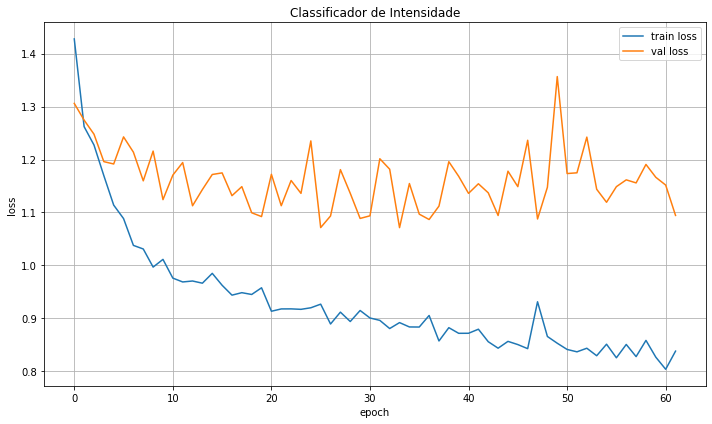

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.title('Classificador de Intensidade')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.tight_layout()
plt.show()

In [47]:
_ = classification_report(
    y_true=[np.argmax(x) for x in ytest],
    y_pred=[np.argmax(x) for x in clf_intensidade.predict(xtest)],
    target_names=DE_PARA_INTENSIDADE.keys()
)

print(_)

              precision    recall  f1-score   support

       fraca       0.75      0.57      0.65        42
    moderada       0.47      0.69      0.56        48
       forte       0.48      0.44      0.46        48
        pico       0.69      0.54      0.61        37

    accuracy                           0.56       175
   macro avg       0.60      0.56      0.57       175
weighted avg       0.59      0.56      0.56       175



In [51]:
#
#
clf_intensidade = K.models.load_model('classificador_intensidade_64mfcc_encoded.hdf5')
#
#

In [52]:
_ = classification_report(
    y_true=[np.argmax(x) for x in ytest],
    y_pred=[np.argmax(x) for x in clf_intensidade.predict(xtest)],
    target_names=DE_PARA_INTENSIDADE.keys(),
    zero_division=0
)

print(_)

              precision    recall  f1-score   support

       fraca       0.73      0.64      0.68        42
    moderada       0.53      0.52      0.53        48
       forte       0.46      0.50      0.48        48
        pico       0.64      0.68      0.66        37

    accuracy                           0.58       175
   macro avg       0.59      0.58      0.59       175
weighted avg       0.58      0.58      0.58       175



#### VERBO

In [53]:
xtest_verbo = np.array([realizar_encoding(x) for x in Xfusao_verbo.values[:,4:]])
pred_verbo = [np.argmax(x) for x in clf_intensidade.predict(xtest_verbo)]

In [54]:
np.array(pred_verbo)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,
       2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1,
       2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Decomposição

In [55]:
LABEL_INTENSIDADE = {
    0: 'fraca',
    1: 'moderada',
    2: 'forte',
    3: 'pico'
}

In [56]:
pred_verbo_label = [LABEL_INTENSIDADE.get(_) for _ in pred_verbo]

In [57]:
pred_vivae_label = [
        LABEL_INTENSIDADE.get(np.argmax(x)) for x in clf_intensidade.predict(x64_vivae_enc)
]

In [58]:
x64_vivae_enc.shape, xtest_verbo.shape

((698, 1, 32), (666, 1, 32))

In [59]:
x64_vivae_enc[0].shape, x64_vivae_enc[0]

((1, 32),
 array([[66.74812 , 58.102753, 14.523589, 50.155376, 20.746174, 68.54863 ,
          8.643888, 51.596825, 22.209528, 71.31043 ,  0.      , 93.30099 ,
          0.      ,  0.      , 23.289465, 56.436127, 51.923656,  0.      ,
         46.599472,  0.      , 40.234974, 84.73856 ,  0.      ,  0.      ,
         57.4577  , 30.495626, 55.132534,  0.      ,  0.      , 60.436375,
          0.      , 28.992472]], dtype=float32))

In [60]:
xtest_verbo[0].shape, xtest_verbo[0]

((1, 32),
 array([[19.744194 , 40.370975 , 28.683765 , 15.620589 , 34.28462  ,
         49.70549  , 32.868843 , 23.246428 , 30.107475 , 20.78526  ,
          0.       , 35.77432  ,  0.       ,  0.       , 12.076253 ,
          7.2456827, 29.189138 ,  0.       , 21.47642  ,  0.       ,
         17.897419 , 22.069971 ,  0.       ,  0.       , 12.623078 ,
         33.08441  , 12.502789 , 26.231625 ,  0.       , 18.265993 ,
          0.       , 33.44192  ]], dtype=float32))

In [61]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [62]:
x64_vivae_enc.shape

(698, 1, 32)

In [63]:
x64_vivae_enc.reshape(698,32)

array([[66.74812 , 58.102753, 14.523589, ..., 60.436375,  0.      ,
        28.992472],
       [30.454514, 73.76361 , 42.783546, ..., 55.1548  ,  0.      ,
        27.892557],
       [56.853527, 68.696686, 29.102907, ..., 40.796795,  0.      ,
        19.307133],
       ...,
       [45.24836 , 68.05511 ,  0.      , ..., 27.230682,  0.      ,
         0.      ],
       [52.71964 , 42.293137, 23.260788, ..., 21.889513,  0.      ,
        16.913307],
       [34.753624, 62.81941 , 30.52774 , ..., 43.953423,  0.      ,
        27.920578]], dtype=float32)

In [64]:
xtest_verbo.shape

(666, 1, 32)

In [65]:
xtest_verbo.reshape(666,32)

array([[19.744194 , 40.370975 , 28.683765 , ..., 18.265993 ,  0.       ,
        33.44192  ],
       [23.4432   , 34.832966 , 18.179    , ..., 21.918077 ,  0.       ,
        32.644165 ],
       [22.222736 , 23.521332 , 22.04034  , ..., 21.301758 ,  0.       ,
        29.7725   ],
       ...,
       [13.252755 , 10.812115 , 26.558434 , ..., 29.514563 ,  0.       ,
        11.596598 ],
       [11.0225935, 19.96419  , 15.416425 , ..., 38.172146 ,  0.       ,
        12.917597 ],
       [12.882201 , 23.534086 , 24.768883 , ..., 42.009804 ,  0.       ,
         9.965909 ]], dtype=float32)

### PCA

@VIVAE MFCCs

In [66]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(Xfusao_vivae.values[:,4:])
Xpca.shape

(698, 2)

In [67]:
df_pca = pd.DataFrame(data=Xpca, columns=('c1', 'c2'))
df_pca['label'] = [LABEL_INTENSIDADE.get(np.argmax(x)) for x in y64_vivae]
df_pca.head()

,c1,c2,label
0,133.956117,-30.721513,fraca
1,8.579295,20.402924,fraca
2,-1.521525,-6.958715,fraca
3,88.178866,-4.884549,fraca
4,11.177695,6.202112,fraca


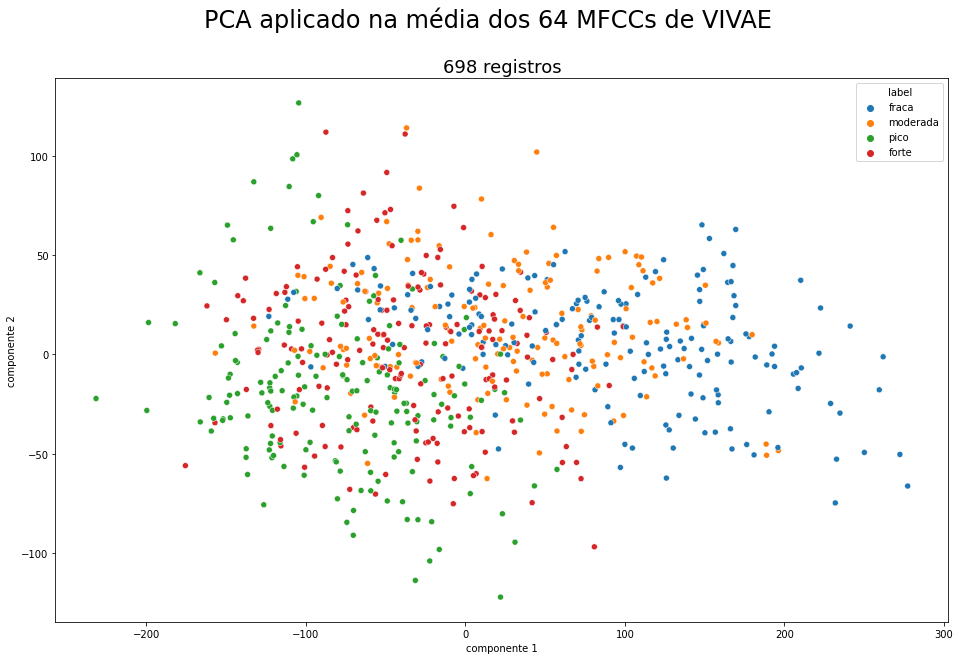

In [68]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label')
plt.suptitle('PCA aplicado na média dos 64 MFCCs de VIVAE', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

plt.show()

@VIVAE AE

In [69]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform([*x64_vivae_enc.reshape(698,32)])
Xpca.shape

(698, 2)

In [70]:
df_pca = pd.DataFrame(data=Xpca, columns=('c1', 'c2'))
df_pca['label'] = [LABEL_INTENSIDADE.get(np.argmax(x)) for x in y64_vivae]
df_pca.head()

,c1,c2,label
0,70.343755,-14.244140,fraca
1,-1.573866,1.325995,fraca
2,0.289367,0.839506,fraca
3,46.440122,0.401760,fraca
4,-1.238857,5.495491,fraca


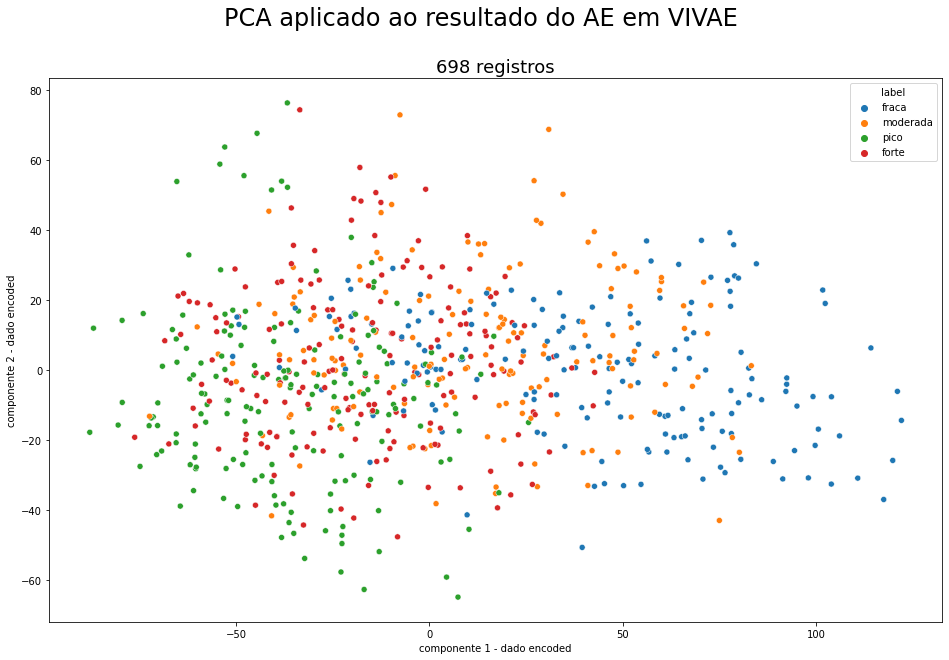

In [71]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label')
plt.suptitle('PCA aplicado ao resultado do AE em VIVAE', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1 - dado encoded')
plt.ylabel('componente 2 - dado encoded')

plt.show()

@AE VERBO e VIVAE

In [72]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform([*x64_vivae_enc.reshape(698,32), *xtest_verbo.reshape(666,32)])
Xpca.shape

(1364, 2)

In [73]:
df_pca = pd.DataFrame(data=Xpca, columns=('c1', 'c2'))
df_pca['label'] = [*pred_vivae_label, *[_ + ' (verbo)' for _ in pred_verbo_label]]
df_pca.head()

,c1,c2,label
0,100.204475,37.216416,fraca
1,43.003369,-4.683926,moderada
2,51.455026,-10.376759,moderada
3,80.049928,23.024286,fraca
4,53.316126,-15.419326,moderada


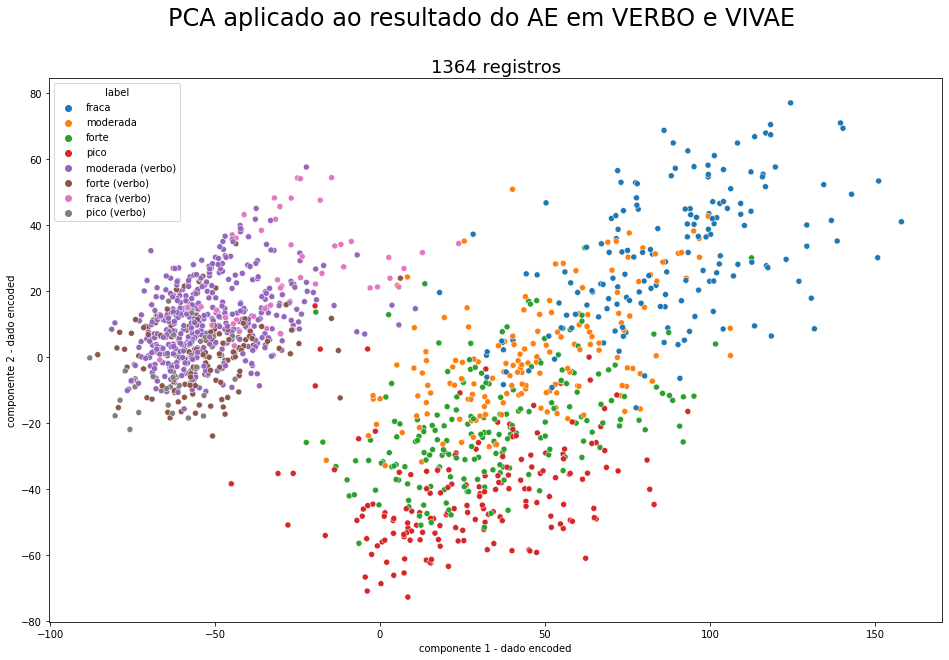

In [74]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label')
plt.suptitle('PCA aplicado ao resultado do AE em VERBO e VIVAE', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1 - dado encoded')
plt.ylabel('componente 2 - dado encoded')

plt.show()

@AE VERBO e VIVAE - 2 Classes

In [78]:
DE_PARA_LABEL_2_CLASSES = {
    'fraca': 'baixa',
    'moderada': 'baixa',
    'forte': 'alta',
    'pico': 'alta',

    'fraca (verbo)': 'baixa (verbo)',
    'moderada (verbo)': 'baixa (verbo)',
    'forte (verbo)': 'alta (verbo)',
    'pico (verbo)': 'alta (verbo)',
}

df_pca['label 2'] = df_pca['label'].apply(lambda x: DE_PARA_LABEL_2_CLASSES.get(x))

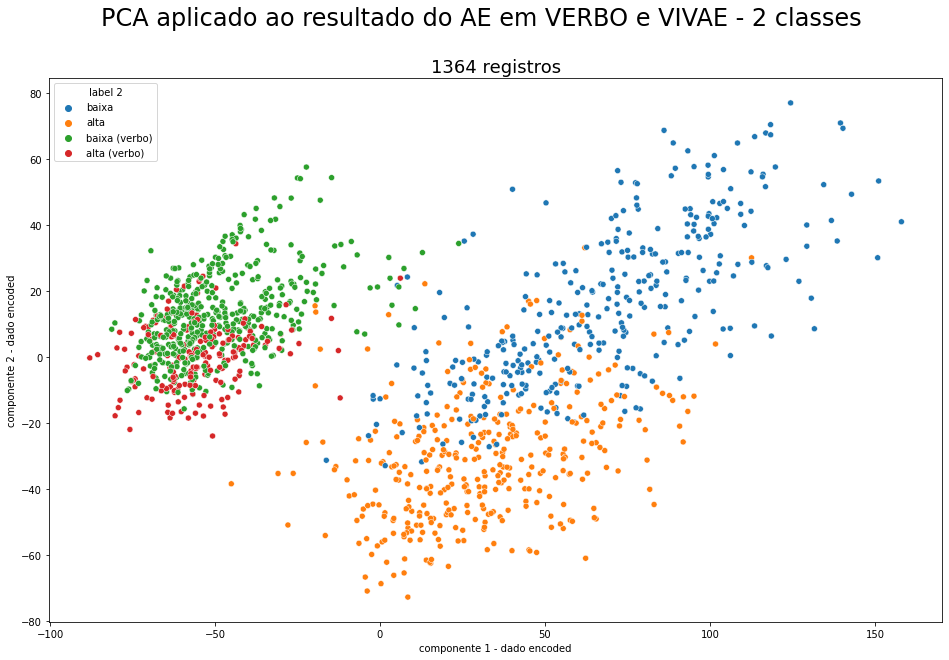

In [79]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label 2')
plt.suptitle('PCA aplicado ao resultado do AE em VERBO e VIVAE - 2 classes', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1 - dado encoded')
plt.ylabel('componente 2 - dado encoded')

plt.show()

___

Refs:

- [62] https://sci-hub.se/10.1109/tmm.2017.2766843
- [63] https://sci-hub.se/10.1016/j.bspc.2018.08.035
- [64] https://arxiv.org/pdf/1712.08708.pdf
- [65] https://sci-hub.se/10.1109/icassp.2018.8462685
- [66] https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9136653
- [67] https://sci-hub.se/10.1109/ectidamtncon48261.2020.9090768
- [68] https://www.isca-speech.org/archive_v0/Interspeech_2019/pdfs/2561.pdf
- https://sci-hub.se/10.7717/peerj.488
